In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import shutil
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
root_dir = '/content/fashion_train_data'
os.makedirs(root_dir, exist_ok=True)
for i in range(10):
    os.makedirs(os.path.join(root_dir, str(i)), exist_ok=True)

In [4]:
trainset = torchvision.datasets.FashionMNIST(root=root_dir, train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9560727.71it/s] 


Extracting /content/fashion_train_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/fashion_train_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 150450.13it/s]


Extracting /content/fashion_train_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/fashion_train_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1403380.76it/s]


Extracting /content/fashion_train_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/fashion_train_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8678567.92it/s]

Extracting /content/fashion_train_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/fashion_train_data/FashionMNIST/raw



In [5]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
def save_images_to_folders(dataset, root_dir):
    for idx, (image, label) in enumerate(tqdm(dataset)):
        label_dir = os.path.join(root_dir, str(label))
        img_path = os.path.join(label_dir, f'{idx}.png')
        torchvision.utils.save_image(image, img_path)

In [7]:
save_images_to_folders(trainset, root_dir)

100%|██████████| 60000/60000 [00:41<00:00, 1456.67it/s]


In [9]:
from PIL import Image

class FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

In [10]:
train_set = FolderDataset(root_dir, transform=transforms.ToTensor())
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [11]:
test_dir = '/content/fashion_test_data'
os.makedirs(test_dir, exist_ok=True)
for i in range(10):
    os.makedirs(os.path.join(test_dir, str(i)), exist_ok=True)

In [12]:
testset = torchvision.datasets.FashionMNIST(root=root_dir, train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(trainset, batch_size=1, shuffle=True)

In [13]:
save_images_to_folders(testset, test_dir)

100%|██████████| 10000/10000 [00:06<00:00, 1441.99it/s]


In [14]:
test_dataset = FolderDataset(test_dir, transform=transforms.ToTensor())

In [15]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
class model1(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(490, out_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = model1(1, 10, 10).to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [17]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train, paths in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))


def validate_function(model, device, validation_dataloader, loss_function, accuracy_function):
  model.eval()
  model = model.to(device)
  validation_loss = 0
  validation_acc = 0

  with torch.inference_mode():
    for X_val, y_val, paths in tqdm(validation_dataloader):
      X_val , y_val = X_val.to(device), y_val.to(device)
      val_logits = model(X_val)
      val_pred = torch.argmax(val_logits, dim=1)
      validation_acc += accuracy_function(y_val, val_pred)
      validation_loss += loss_function(val_logits, y_val)
  return validation_loss/len(validation_dataloader), validation_acc/len(validation_dataloader)

In [ ]:
# using pretrained weights for this model

# epochs = 5
# for epoch in range(epochs):
#   train_loss, trng_acc = train_function(model, device, train_loader, loss_fn, optimizer)
#   val_loss, val_acc = validate_function(model, device, test_loader, loss_fn, accuracy_function)
#   print(f'Epoch {epoch}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: Training Loss: 0.5754, Training Accuracy: 78.9967, Val Loss: 0.3859, Val Accuracy: 85.8826


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Training Loss: 0.3475, Training Accuracy: 87.5433, Val Loss: 0.3376, Val Accuracy: 87.6797


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.3104, Training Accuracy: 88.8833, Val Loss: 0.3497, Val Accuracy: 87.1905


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.2919, Training Accuracy: 89.5467, Val Loss: 0.3169, Val Accuracy: 88.1889


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.2775, Training Accuracy: 89.9717, Val Loss: 0.3087, Val Accuracy: 88.9277


In [19]:
train_loader1 = DataLoader(train_set, batch_size=1, shuffle=True)

In [20]:
y_preds = []
y_true = []

model.eval()
with torch.inference_mode():
  for img, label, _ in tqdm(train_loader1):
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    _, pred = torch.max(outputs, dim=1)
    y_preds.append(pred.item())
    y_true.append(label.item())

  0%|          | 0/60000 [00:00<?, ?it/s]

In [21]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

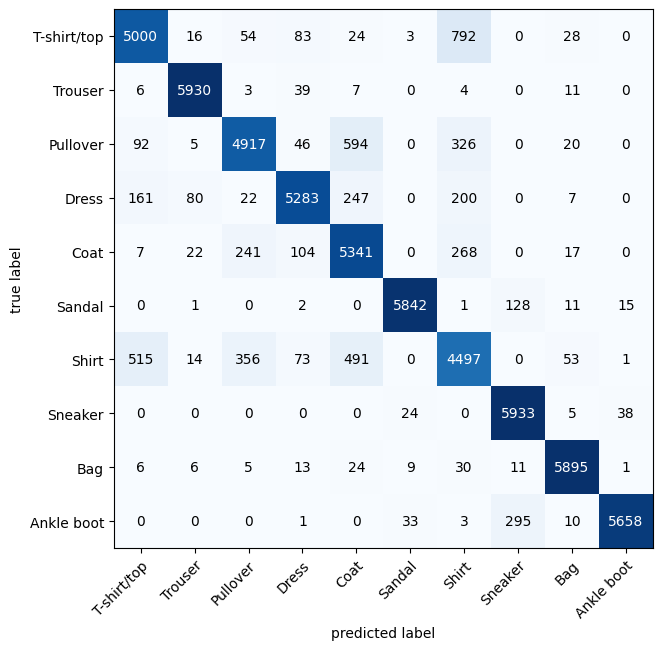

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=torch.tensor(y_preds),
                         target=torch.tensor(y_true))


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [23]:
import shutil
import torch
from torchvision import transforms
from torch.utils.data import DataLoader


# Create directories for misclassified images
os.makedirs('/content/fashion_train_data/misclassified_tshirt_as_shirt', exist_ok=True)
# os.makedirs('/content/fashion_train_data/misclassified_shirt_as_tshirt', exist_ok=True)

tshirt_index = 0
shirt_index = 6

In [24]:
model.eval()
with torch.no_grad():
    for images, labels, paths in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img, true_label, pred_label, img_path in zip(images, labels, predicted, paths):
            if true_label.item() == tshirt_index and pred_label.item() == shirt_index:
                shutil.move(img_path, '/content/fashion_train_data/misclassified_tshirt_as_shirt')
            # elif true_label.item() == shirt_index and pred_label.item() == tshirt_index:
            #     shutil.move(img_path, '/content/fashion_train_data/misclassified_shirt_as_tshirt')

In [25]:
shutil.rmtree('/content/fashion_train_data/FashionMNIST')

In [26]:
shutil.rmtree('/content/fashion_train_data/misclassified_tshirt_as_shirt')
# shutil.rmtree('/content/fashion_train_data/misclassified_shirt_as_tshirt')

## After removing/reassigning, make new folderdataset class load in the data


In [27]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class FolderDataset2(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # if want to reassign labels, just add in the folder name misclassified images into the label_mapping as the key and the new label as the value.
        #e.g change label of tshirt to shirt -> 'misclassified_tshirt_as_shirt': 6
        label_mapping = {
            '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
            '5': 5, '6': 6, '7': 7, '8': 8, '9': 9
        }

        # Process each subdirectory in the root directory
        for label_dir in os.listdir(root_dir):
            full_dir_path = os.path.join(root_dir, label_dir)
            if os.path.isdir(full_dir_path):
                label = label_mapping.get(label_dir, None)
                if label is not None:
                    for img_name in os.listdir(full_dir_path):
                        img_path = os.path.join(full_dir_path, img_name)
                        if os.path.isfile(img_path):
                            self.image_paths.append(img_path)
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path





In [28]:
new_train_dataset = FolderDataset2(root_dir, transform=transforms.ToTensor())

In [29]:
new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)

In [30]:
model2 = model1(1, 10, 10).to(device)

In [31]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [32]:
#train new model with the new data
for epoch in range(5):
  train_loss, trng_acc = train_function(model2, device, new_train_loader, loss_fn, optimizer)
  print(f'Epoch {epoch}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f}')

  0%|          | 0/1851 [00:00<?, ?it/s]

Epoch 0: Training Loss: 0.5752, Training Accuracy: 79.3996


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/1851 [00:00<?, ?it/s]

Epoch 1: Training Loss: 0.3405, Training Accuracy: 87.9103


  0%|          | 0/1851 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.3057, Training Accuracy: 89.1596


  0%|          | 0/1851 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.2845, Training Accuracy: 89.9058


  0%|          | 0/1851 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.2711, Training Accuracy: 90.3262


In [33]:
train_loader2 = DataLoader(new_train_dataset, batch_size=1, shuffle=True)

In [34]:
y_preds = []
y_true = []

model2.eval()
with torch.inference_mode():
  for img, label, _ in tqdm(train_loader2):
    img, label = img.to(device), label.to(device)
    outputs = model2(img)
    _, pred = torch.max(outputs, dim=1)
    y_preds.append(pred.item())
    y_true.append(label.item())


  0%|          | 0/59208 [00:00<?, ?it/s]

In [35]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

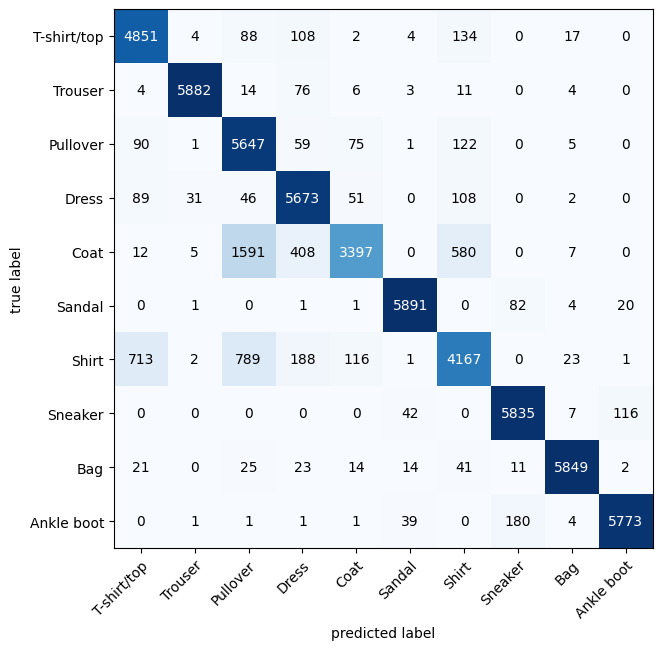

In [36]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=torch.tensor(y_preds),
                         target=torch.tensor(y_true))


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);